

 **regression problems**, the concepts of **under/over-fitting**, and **regularization**. 

 [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset.

In [3]:
import torch
from torch import nn
from sklearn import model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from IPython import display

import typing
%matplotlib inline

In [4]:
diabetes_db = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t', header=0)
#sn.pairplot(diabetes_db)

In [5]:
diabetes_db.head(10)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.00,4.2905,80,135
5,23,1,22.6,89.0,139,64.8,61.0,2.00,4.1897,68,97
6,36,2,22.0,90.0,160,99.6,50.0,3.00,3.9512,82,138
7,66,2,26.2,114.0,255,185.0,56.0,4.55,4.2485,92,63
8,60,2,32.1,83.0,179,119.4,42.0,4.00,4.4773,94,110
9,29,1,30.0,85.0,180,93.4,43.0,4.00,5.3845,88,310


We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [6]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'],
    diabetes_db['Y'],
    test_size=0.2,
    random_state=42
    )
x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1)

print(x_train)

tensor([[68.0000,  2.0000, 27.5000,  ...,  5.0000,  4.9416, 91.0000],
        [46.0000,  2.0000, 24.7000,  ...,  6.0000,  4.6444, 96.0000],
        [50.0000,  1.0000, 31.0000,  ...,  4.0000,  4.8283, 88.0000],
        ...,
        [57.0000,  1.0000, 24.5000,  ...,  3.0000,  4.5218, 91.0000],
        [45.0000,  1.0000, 24.2000,  ...,  4.0000,  4.2195, 82.0000],
        [23.0000,  1.0000, 29.0000,  ...,  3.0000,  4.5850, 91.0000]])


We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

**Q1.** Complete the method and normalize `x_train, x_test` [2 marks]

In [7]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
  x = (x-mu)/sigma
  return x
mu_train = torch.mean(x_train, dim = 0)
mu_test = torch.mean(x_train, dim = 0)

sigma_train = torch.std(x_train, dim = 0)
sigma_test = torch.std(x_train, dim = 0)
x_train = norm_set(x_train, mu_train, sigma_train)
x_test = norm_set(x_test, mu_test, sigma_test)




In [8]:
print(sigma_train) #+ sigma_test + x_train + x_test)
print(mu_train)
print(x_train.std(dim=0))

tensor([12.7553,  0.4998,  4.3862, 14.0781, 34.7292, 30.4208, 12.7779,  1.2951,
         0.5247, 11.6801])
tensor([ 48.9150,   1.4703,  26.5368,  94.9896, 188.7365, 114.9244,  49.5198,
          4.0805,   4.6548,  91.7167])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## 1.1 Linear Regression

We will building the linear regression model in pytorch using a custom layer. 

Refering back to the lecture notes, we define $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

**Q2.** Fill in the forward method of the LinearRegression class. [2 marks]

In [9]:

class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)
    #self.bias = nn.Parameter(torch.zeros(1), requires_grad=False)
  
  def forward(self, x):
    
    #y = x @ self.weight.t()
    y = torch.matmul(x, self.weight.T) 
    #y = torch.matmul(self.weight.t(), x)
    
    return y


As we need to account for the bias, we add a column of ones to the `x_data`

In [10]:
# add a feature for bias
x_train = torch.cat([x_train, torch.ones(x_train.shape[0], 1)], dim=1)
x_test = torch.cat([x_test, torch.ones(x_test.shape[0], 1)], dim=1)

In [11]:
## test the custom layer
model = LinearRegression(x_train.shape[1])
prediction = model(x_train)
prediction.shape # the output should be Nx1

torch.Size([353, 1])

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

**Q3.** Fill in the method to calculate the squared error of for any set of labels $y$ and predictions [2 marks]

In [12]:

def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
  #loss = nn.MSELoss()
  #output= loss(y_true,y_pred)
  
  difference = y_true - y_pred
  return torch.sum(difference * difference)/ difference.numel()

In [13]:
cost = mean_squared_error(y_train, prediction)
print(cost)

tensor(29711.3223)


In [14]:



def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  weight = model.weight
  #bias = model.bias
  N = X.shape[0]
  # calculate the partial derivative of the loss funct"ion with respect to w_0 and w_1
  weight_d = torch.zeros(weight.shape[0], weight.shape[1])
  weight_d = (-2) * sum(torch.mul(X,(y-y_pred)))/N
  weight -= weight_d*lr
  #bias -=  Dw1 * lr
  # calculate the new values for bias and weight
  ### NEED TO VECTORIZE THE WEIGHTS AND THEN TRY Weight = Vector of the weights [11,1] oe [1,11]
  model.weight = nn.Parameter(weight, requires_grad=False)
  #model.bias = nn.Parameter(bias, requires_grad=False) 

  
  

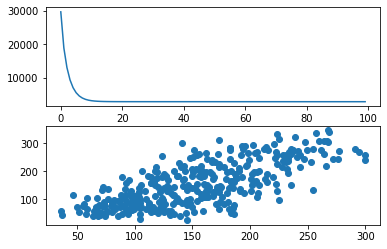

Parameter containing:
tensor([[  1.9400, -11.4488,  26.3047,  16.6306,  -9.8810,  -2.3179,  -7.6995,
           8.2121,  21.9769,   2.6065, 153.7365]])
Minimum cost: 2890.406494140625


In [15]:
cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = .1
for it in range(100):
  prediction = model(x_train)
  cost = mean_squared_error(y_train, prediction)
  cost_lst.append(cost)
  gradient_descent_step(model, x_train, y_train, prediction, alpha)
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
axs[1].scatter(prediction, y_train)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

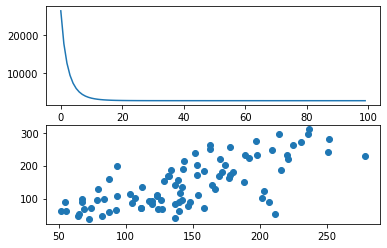

Parameter containing:
tensor([[ -6.3173, -12.3420,  20.5094,  11.0672,   4.4981,  -2.6394, -12.8705,
          -5.3701,  32.5305,   7.8895, 156.3743]])
Minimum cost: 2568.32763671875


In [16]:
cost_lst = list()
model = LinearRegression(x_test.shape[1])
alpha = .1
for it in range(100):
  prediction = model(x_test)
  cost = mean_squared_error(y_test, prediction)
  cost_lst.append(cost)
  gradient_descent_step(model, x_test, y_test, prediction, alpha)
fig, axs = plt.subplots(2)
axs[0].plot(list(range(it+1)), cost_lst)
axs[1].scatter(prediction, y_test)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

In [17]:
#Find the estimation of the two rows by standardizing the data (z = x-mu/sigma)
x_example = [
    [25,2,18,79,130,64.8,61,2,4.1897,68],
    [50,1,28,103,229,162.2,60,4.5,6.107,124]
    ]
x_example_set = torch.tensor(x_example)
x_set_m = torch.mean(x_example_set, dim=0)
x_e_s = torch.std(x_example_set, dim=0)
x_set = norm_set(x_example_set, x_set_m, x_e_s)
x_set = torch.cat([x_set, torch.ones(x_set.shape[0], 1)], dim=1)
print(x_set)
y = model(x_set)
print(y)


tensor([[-0.7071,  0.7071, -0.7071, -0.7071, -0.7071, -0.7071,  0.7071, -0.7071,
         -0.7071, -0.7071,  1.0000],
        [ 0.7071, -0.7071,  0.7071,  0.7071,  0.7071,  0.7071, -0.7071,  0.7071,
          0.7071,  0.7071,  1.0000]])
tensor([[ 94.5869],
        [218.1616]])


In [18]:
### your code here
prediction_test = model(x_test)
cost_test = mean_squared_error(y_test, prediction_test)
print(cost_test)

tensor(2568.2971)


Error on training set with alpha 1000 is : 29711.322265625
Error on test set with alpha 1000 is nan

Error on training set with alpha 100 is : 29711.322265625
Error on test set with alpha 100 is nan

Error on training set with alpha 10 is : 29711.322265625
Error on test set with alpha 10 is nan

Error on training set with alpha 1 is : 29711.322265625
Error on test set with alpha 1 is nan

Error on training set with alpha 0.1 is : 2890.406494140625
Error on test set with alpha 0.1 is 2885.619140625

Error on training set with alpha 0.01 is : 3356.77685546875
Error on test set with alpha 0.01 is 3431.068359375

Error on training set with alpha 0.001 is : 20040.583984375
Error on test set with alpha 0.001 is 18534.30859375



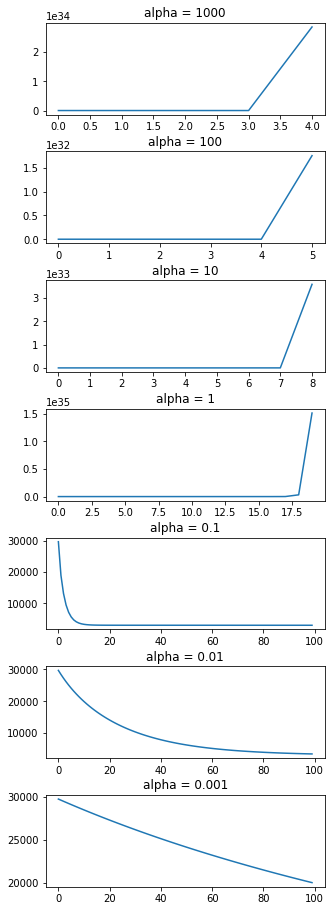

In [19]:
alpha_values = [1000, 100, 10, 1, 0.1, 0.01, 0.001]
fig, axs = plt.subplots(7, 1, figsize=(5,15))
plt.subplots_adjust(bottom=0.1,top=0.9,wspace=0.4,hspace=0.4)
i = 0
for alpha in alpha_values:
    cost_lst = list()
    model = LinearRegression(x_train.shape[1])
    
    for it in range(100):
        prediction = model(x_train)
        cost = mean_squared_error(y_train, prediction)
        cost_lst.append(cost)
        gradient_descent_step(model, x_train, y_train, prediction, alpha)
    print('Error on training set with alpha {} is : {}'.format(alpha, min(cost_lst)))
    prediction_test = model(x_test)
    test_set_error = mean_squared_error(y_test, prediction_test)
    print('Error on test set with alpha {} is {}\n'.format(alpha, test_set_error))
    axs[i].plot(list(range(it+1)), cost_lst)
    axs[i].set_title('alpha = {}'.format(alpha))
    i = i + 1

Error on training set with alpha 2000 is : 29711.322265625
Error on test set with alpha 2000 is nan

Error on training set with alpha 200 is : 29711.322265625
Error on test set with alpha 200 is nan

Error on training set with alpha 20 is : 29711.322265625
Error on test set with alpha 20 is nan

Error on training set with alpha 2 is : 29711.322265625
Error on test set with alpha 2 is nan

Error on training set with alpha 0.2 is : 2883.7109375
Error on test set with alpha 0.2 is 2886.526123046875

Error on training set with alpha 0.02 is : 2906.43505859375
Error on test set with alpha 0.02 is 2906.97900390625

Error on training set with alpha 0.002 is : 14224.037109375
Error on test set with alpha 0.002 is 13523.140625



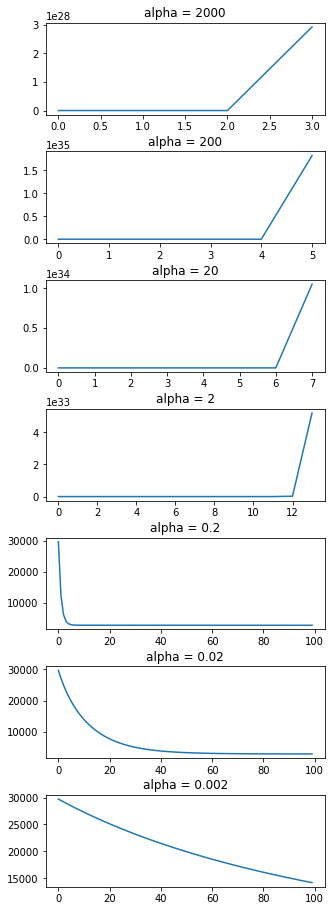

In [20]:
alpha_values = [2000, 200, 20, 2, 0.2, 0.02, 0.002]
fig, axs = plt.subplots(7, 1, figsize=(5,15))
#plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.4,hspace=0.4)
plt.subplots_adjust(bottom=0.1,top=0.9,wspace=0.4,hspace=0.4)
i = 0
for alpha in alpha_values:
    cost_lst = list()
    model = LinearRegression(x_train.shape[1])
    
    for it in range(100):
        prediction = model(x_train)
        cost = mean_squared_error(y_train, prediction)
        cost_lst.append(cost)
        gradient_descent_step(model, x_train, y_train, prediction, alpha)
    print('Error on training set with alpha {} is : {}'.format(alpha, min(cost_lst)))
    prediction_test = model(x_test)
    test_set_error = mean_squared_error(y_test, prediction_test)
    print('Error on test set with alpha {} is {}\n'.format(alpha, test_set_error))
    axs[i].plot(list(range(it+1)), cost_lst)
    axs[i].set_title('alpha = {}'.format(alpha))
    i = i + 1

torch.Size([7, 1])
torch.Size([7, 1])


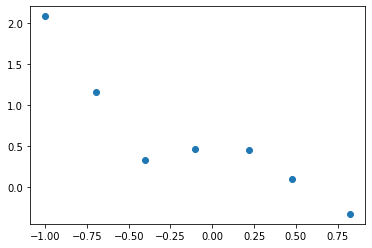

In [21]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229]).reshape(-1, 1)
print(x.shape)
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013, 0.44808, 0.10013, -0.32952]).reshape(-1, 1)
print(y.shape)
plt.scatter(x, y)
plt.show()

In [22]:
### remember to add x_0 for the bias

class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1, num_features), requires_grad=False)
  
  def forward(self, x):
    y = torch.matmul(x, self.weight.T)
    return y

x3 = torch.cat([x ** i for i in range(0, 6)], 1)
print(x3.shape)

torch.Size([7, 6])


In [23]:
def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor, lam: float, theta: torch.tensor) -> torch.Tensor:
    m = y_pred.shape[0] 
    cost = (torch.sum(torch.square(y_pred-y_true)) + lam*torch.sum(torch.square(theta)))/(2*m)
    return cost

  

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float, lam: float) -> None:
  weight = model.weight
  m = y_pred.shape[0]

  initial_Weight = weight[0,0] - lr/m*(torch.sum(torch.mul((y_pred-y), X)))
  weight = weight*(1-lr*lam/m) - lr/m*(sum(torch.mul((y_pred-y), X)))
  weight[0,0] = initial_Weight

  model.weight = nn.Parameter(weight, requires_grad=False)

In [24]:
x3  

tensor([[ 1.0000e+00, -9.9768e-01,  9.9537e-01, -9.9306e-01,  9.9075e-01,
         -9.8845e-01],
        [ 1.0000e+00, -6.9574e-01,  4.8405e-01, -3.3678e-01,  2.3431e-01,
         -1.6302e-01],
        [ 1.0000e+00, -4.0373e-01,  1.6300e-01, -6.5807e-02,  2.6568e-02,
         -1.0726e-02],
        [ 1.0000e+00, -1.0236e-01,  1.0478e-02, -1.0725e-03,  1.0978e-04,
         -1.1237e-05],
        [ 1.0000e+00,  2.2024e-01,  4.8506e-02,  1.0683e-02,  2.3528e-03,
          5.1818e-04],
        [ 1.0000e+00,  4.7742e-01,  2.2793e-01,  1.0882e-01,  5.1952e-02,
          2.4803e-02],
        [ 1.0000e+00,  8.2229e-01,  6.7616e-01,  5.5600e-01,  4.5719e-01,
          3.7595e-01]])

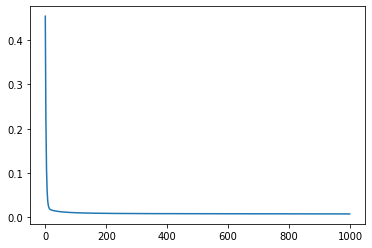

Parameter containing:
tensor([[ 0.3761, -0.2380,  0.1442, -0.9423,  0.0837, -0.3480]])
Minimum cost: 0.007786668371409178


In [31]:
cost_lst = list()
print(x3.shape[1])
model = LinearRegression(x3.shape[1])
alpha = .2 # select an appropriate alpha
lam = 0 # select an appropriate lambda
for it in range(1000):
  prediction = model(x3)
  #print(prediction.shape)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

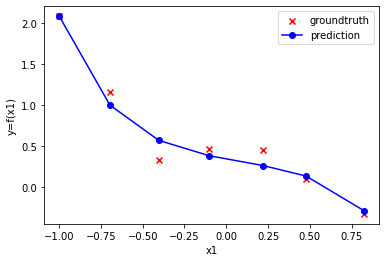

In [26]:
plt.scatter(x3[:, 1], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 1], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

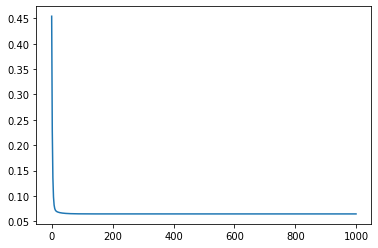

Parameter containing:
tensor([[ 0.2456, -0.4201,  0.2529, -0.3931,  0.2208, -0.3321]])
Minimum cost: 0.064546599984169


In [27]:
cost_lst = list()
print(x3.shape[1])
model = LinearRegression(x3.shape[1])
alpha = 0.2 # select an appropriate alpha
lam = 1 # select an appropriate lambda
for it in range(1000):
  prediction = model(x3)
  #print(prediction.shape)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

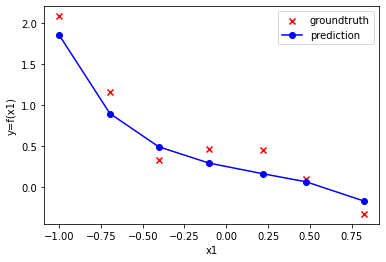

In [28]:
plt.scatter(x3[:, 1], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 1], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()

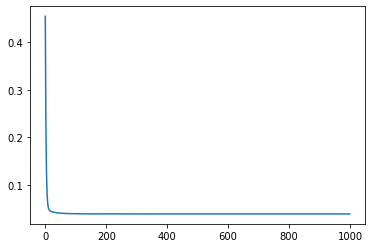

Parameter containing:
tensor([[ 0.2801, -0.4326,  0.2380, -0.4560,  0.2073, -0.3726]])
Minimum cost: 0.03928555175662041


In [29]:
cost_lst = list()
print(x3.shape[1])
model = LinearRegression(x3.shape[1])
alpha = 0.2 # select an appropriate alpha
lam = 0.5 # select an appropriate lambda
for it in range(1000):
  prediction = model(x3)
  #print(prediction.shape)
  cost = mean_squared_error(y, prediction, lam, model.weight)
  cost_lst.append(cost)
  gradient_descent_step(model, x3, y, prediction, alpha, lam)
display.clear_output(wait=True)
plt.plot(list(range(it+1)), cost_lst)
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

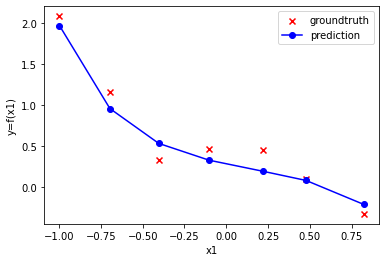

In [30]:
plt.scatter(x3[:, 1], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, 1], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()